# Text Sentiment analysis

In [ ]:
from flask import Flask,render_template,request

import torch
import pandas as pd
import numpy as np
import re
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer,BertConfig
from torch import nn, optim
import spacy
import string
import pke

from nltk.corpus import stopwords
import spacy

from selectorlib import Extractor
import requests
import json
from time import sleep
import csv
from dateutil import parser as dateparser
import datetime




In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

import pandas as pd
pd.set_option('display.max_rows', 500)


In [ ]:
config = BertConfig.from_json_file('./bertuncased/bert_config.json')


path = "modelSent/sentiment.pt"

# Create the BertClassfier class

tokenizer = BertTokenizer.from_pretrained("./bertuncased/",config=config, do_lower_case=True)


In [ ]:
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert =BertModel.from_pretrained("./bertuncased/",config=config)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    #print('No GPU available, using the cpu')


model = BertClassifier()
#model.load_state_dict(torch.load('model_state.pth'))
#model.load_state_dict(path,map_location=torch.device('cpu'))

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
MAX_LEN = 64

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        #print("sent",sent)
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,#Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        #print("encoded_sent",encoded_sent)
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors

    input_ids = torch.tensor(input_ids)
    attention_masks =torch.tensor(attention_masks)

    return input_ids, attention_masks

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    #model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

def query(sentence):
    labels = {2:"Negative",0:"Neutral",1:"Positive"}
    qwery = pd.DataFrame([sentence],columns=["text"])
    te_inputs, te_masks = preprocessing_for_bert(qwery.text)
    te_dataset = TensorDataset(te_inputs, te_masks)
    te_sampler = SequentialSampler(te_dataset)
    te_dataloader = DataLoader(te_dataset, sampler=te_sampler, batch_size=1)
    k=bert_predict(model, te_dataloader)
    print(k)
    for i in k:
        print(max(i))
    return labels[np.argmax(k,axis=1)[0]]

def getSentiments(sentence):
    qwery = pd.DataFrame([sentence],columns=["text"])
    te_inputs, te_masks = preprocessing_for_bert(qwery.text)
    te_dataset = TensorDataset(te_inputs, te_masks)
    te_sampler = SequentialSampler(te_dataset)
    te_dataloader = DataLoader(te_dataset, sampler=te_sampler, batch_size=1)
    k=bert_predict(model, te_dataloader)
    print(k)
    for i in k:
        print(max(i))
    return np.argmax(k,axis=1)[0]

def SentimentsOnLongDocs(articles,AllSent = False):
    labels = {2:"Negative",0:"Neutral",1:"Positive"}
    sentence = articles
    #sentence = articles.split(". ")
    SentSentiments =[]
    meanValue = 0
    for text in sentence:
        S = getSentiments(text)
        SentSentiments.append(S)
        #print(SentSentiments)
        meanValue+=S

    return SentSentiments

In [ ]:
sp_lg = spacy.load("en")
# Create an Extractor by reading from the YAML file
e = Extractor.from_yaml_file('D:/TextSentimentAPI/twint/amazon-review-scraper/selectors.yml')


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import widgets, interact
from scipy.stats import skewnorm
import pke
from nltk.corpus import stopwords
import numpy as np
import pandas as pd




def EntityExtraction(text):
    """
    Get the entity extracted
    """
    return {(ent.text.strip(), ent.label_) for ent in sp_lg(text).ents}


def  KeyWordExtraction(text):
    """
    Outputs the Keywords from the text
    """
    pos = {'NOUN', 'PROPN', 'ADJ'}
    extractor = pke.unsupervised.SingleRank()
    extractor.load_document(input=text,
                            language='en',
                            normalization=None)
    extractor.candidate_selection(pos=pos)
    extractor.candidate_weighting(window=10,
                                  pos=pos)
    keyphrases = extractor.get_n_best(n=10)

    idx = 941
    values= []
    for k in keyphrases:
        values.append(k[0])
    return values


def get_entities(text):
    """
    Format output from EntityExtraction
    """
    df = pd.DataFrame()
    text_list, entity_type = [], []
    for string_vals in text:
#         print(string_vals)
        entity_extract = EntityExtraction(string_vals)
        for i, j in entity_extract:
    #     print(entity_extract)
            text_list.append(i)
            entity_type.append(j)
    df['entities'] = text_list
    df['entity_type'] = entity_type
    return df


def get_keywords(text):
    keywords = []
#     text = text.split('.')
    for string_vals in text:
        keywords.append(KeyWordExtraction(string_vals))
#         if len(keywords[-1]) >= 1 and keywords[-1] != [' ']: 
#             print(keywords[-1])
    keywords = [item for sublist in keywords for item in sublist]
    return pd.DataFrame(keywords, columns = ['keywords'])


In [ ]:
def scrape_format():
    def scrape(url):
        headers = {
            'authority': 'www.amazon.com',
            'pragma': 'no-cache',
            'cache-control': 'no-cache',
            'dnt': '1',
            'upgrade-insecure-requests': '1',
            'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
            'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'sec-fetch-site': 'none',
            'sec-fetch-mode': 'navigate',
            'sec-fetch-dest': 'document',
            'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
        }

        # Download the page using requests
        print("Downloading %s"%url)
        r = requests.get(url, headers=headers,verify=False)
        # Simple check to check if page was blocked (Usually 503)
        if r.status_code > 500:
            if "To discuss automated access to Amazon data please contact" in r.text:
                print("Page %s was blocked by Amazon. Please try using better proxies\n"%url)
            else:
                print("Page %s must have been blocked by Amazon as the status code was %d"%(url,r.status_code))
            return None
        # Pass the HTML of the page and create
        return e.extract(r.text)
    
    def retu():
        df=pd.read_csv("data.csv")
        return df["content"]

    # product_data = []
    with open("D:/TextSentimentAPI/twint/amazon-review-scraper/urls.txt",'r',encoding="utf-8") as urllist, open('data.csv','w',encoding="utf-8") as outfile:
        writer = csv.DictWriter(outfile, fieldnames=["title","content","date","variant","images","verified","author","rating","product","url"],quoting=csv.QUOTE_ALL)
        writer.writeheader()
        for url in urllist.readlines():
            data = scrape(url)
            #print(data)
            if data:
                for r in data['reviews']:
                    r["product"] = data["product_title"]
                    r['url'] = url
                    if 'verified' in r:
                        if 'Verified Purchase' in r:
                            r['verified'] = 'Yes'
                        else:
                            r['verified'] = 'Yes'
                    #r['rating'] = r['rating'].split(' out of')[0]
                    date_posted = r['date'].split('on ')[-1]
                    if r['images']:
                        r['images'] = "\n".join(r['images'])
                    r['date'] = dateparser.parse(date_posted).strftime('%d %b %Y')
                    writer.writerow(r)
    
    #print("CSV Made!")
    
    return retu()
    
    
    

 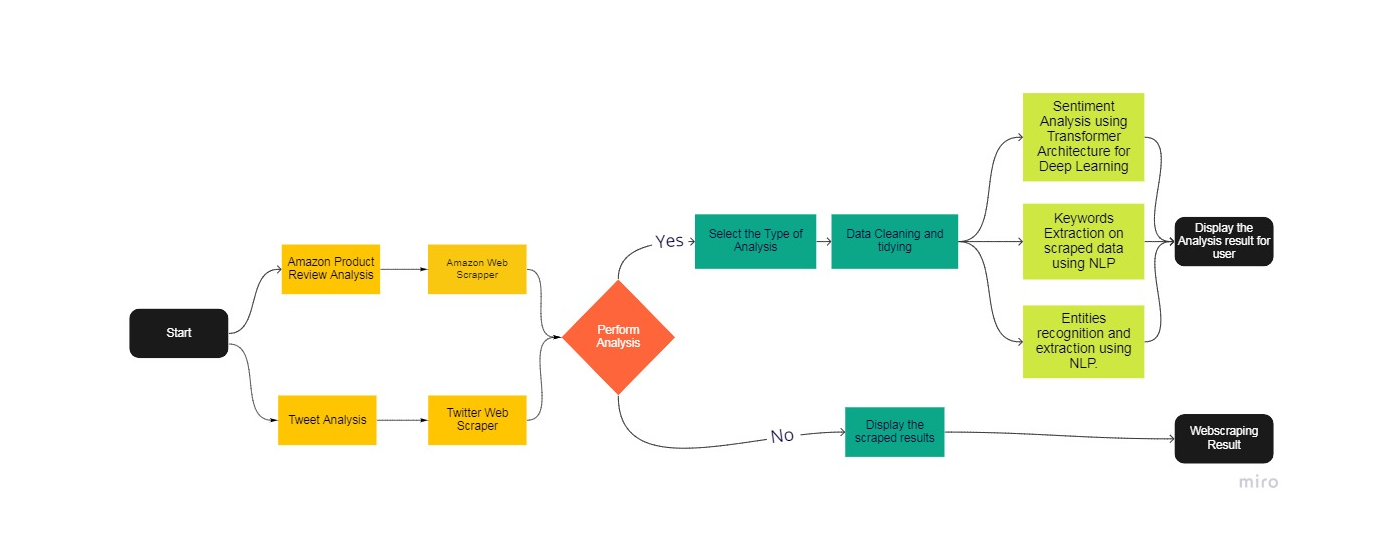

# Amazon Product Review Analysis

# Insert Amazon Review link for any product. 

In [ ]:
## Code for Nidhi Priya: Sentiment Analysis

button1 = widgets.Button( description= 'Sentiments!' , icon = 'check')
button2 = widgets.Button( description = 'Entities!', icon = 'check')
button3 = widgets.Button( description = 'Keywords!', icon = 'check')
output = widgets.Output()
q = widgets.Text()

#print(q)


def reduce_url(q):
    #out.clear_output()
    
    str_list = q.split(' ')
#     df = pd.DataFrame(str_list, columns = ['str_list'])
#     df_sentiment, df_keywords, df_entities = df.copy(), df.copy(), df.copy()
#     display(df)
    q = str_list
    l= str(str_list) #converted to string 
    #dummy_df = pd.DataFrame()
    #dummy_df.iloc[-1] = l
    #dummy_df.to_csv('D:/TextSentimentAPI/twint/amazon-review-scraper/dummy_urls.csv')
    f = open('D:/TextSentimentAPI/twint/amazon-review-scraper/url.txt', 'r+')
    f.truncate(0) 
    f = open("D:/TextSentimentAPI/twint/amazon-review-scraper/url.txt", "w")
    f.write(l)
    f.close()
    
    with open('D:/TextSentimentAPI/twint/amazon-review-scraper/url.txt', 'r') as my_file:
        text = my_file.read()
        text = text.replace("[", "")
        text = text.replace("]", "")
        text = text.replace("'", "")
        text = text.replace("'", "")
    with open('D:/TextSentimentAPI/twint/amazon-review-scraper/urls.txt', 'w') as my_file:
        my_file.write(text)
    df = scrape_format()
    display(df)
    return df
out = widgets.interactive_output(reduce_url, {'q':q})


def get_sentiments_analysis(b):
    """For Nidhi: Make calls here to your code + model and return the sentiment"""
    ## Dummy sentiments replace it with real scores for sentences
    out.clear_output() #Do not change
    df_sentiment = pd.DataFrame()
    df_sentiment['str_list'] = scrape_format().copy()
    #j=SentimentsOnLongDocs(str_list,AllSent = False)
    #print(j)
    #df_sentiment['sentiment_probability_neutral']=j[0]
    #df_sentiment['sentiment_probability_positve']=j[1]
    #df_sentiment['sentiment_probability_negative']=j[2]
    #df_sentiment['sentiment_overall'] = j[3]#SentimentsOnLongDocs(str_list,AllSent = False) #Dataframe creation demo
    df_sentiment['sentiment'] =SentimentsOnLongDocs(df_sentiment['str_list'],AllSent = False)
    """Insert the code here and change output to Dataframe"""
    ## Do not change
    with output:
        output.clear_output()
        display(df_sentiment)
        return df_sentiment

def get_entities_analysis(b):
#     """For Nidhi: Make calls here to your code + model and return the sentiment"""
#     ## Dummy 
#     ### Get the entities here
    out.clear_output() #Do not change
    """Insert the code here and change output to Dataframe"""
    df = scrape_format().copy()
    str_list = df.values
    df_entities = get_entities(str_list)
    df_entities['frequency_count'] = df_entities['entity_type'].map(df_entities['entity_type'].value_counts())
    
    #Do not change
    with output:
        output.clear_output()
        display(df_entities)
        return df_entities

def get_keywords_analysis(b):
#     """For Nidhi: Make calls here to your code + model and return the sentiment"""
#     ## Dummy 
    """get keywords extractor here"""
    out.clear_output() ## Do not change
    """Insert the code here and change output to Dataframe"""
    df = scrape_format().copy()
    str_list = df.values
    df_keywords = get_keywords(str_list)
    ## Do not change
    with output:
        output.clear_output()
        display(df_keywords)
        return df_keywords




# widgets.VBox([q, out])
button1.on_click(get_sentiments_analysis)
button2.on_click(get_entities_analysis)
button3.on_click(get_keywords_analysis)
# interface_sentiment = widgets.VBox([q, button1, button2, button3]) # out,
#interface_sentiment = widgets.VBox([q, button1, button2, button3, out]) # out,
#widgets.HBox([interface_sentiment,  output])
widgets.VBox([q, button1, button2, button3, out,output])
#"""Out of the night that covers me,  Black as the pit from pole to pole"""

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()

In [ ]:
def extr(x):
    c = twint.Config()
    #c.Username = "narendramodi"
    c.Limit = 1
    c.Search = [x]
    # Run
    c.Pandas = True
    twint.limit=20
    twint.run.Search(c)
    Tweets_df = twint.storage.panda.Tweets_df
    
    return Tweets_df["tweet"]


# Twitter Tweets Analysis

# Insert the twitter query sentence

In [ ]:
button4 = widgets.Button( description= 'Sentiments!' , icon = 'check')
button5 = widgets.Button( description = 'Entities!', icon = 'check')
button6 = widgets.Button( description = 'Keywords!', icon = 'check')
output1 = widgets.Output()
q1 = widgets.Text()


def reduce_url1(q):
    global str_list
    str_list = q1
    df = extr(str_list)
  
    return df
out1 = widgets.interactive_output(reduce_url1, {'q':q1})

out1.clear_output()
str_list = q1

def get_sentiments_analysis1(b):
    """For Nidhi: Make calls here to your code + model and return the sentiment"""
    ## Dummy sentiments replace it with real scores for sentences
    out1.clear_output() #Do not change
    df_sentiment = pd.DataFrame()
    df_sentiment['str_list'] = extr(str_list).copy()
    df_sentiment['sentiment'] =SentimentsOnLongDocs(df_sentiment['str_list'],AllSent = False)
    """Insert the code here and change output to Dataframe"""
    ## Do not change
    with output1:
        output1.clear_output()
        display(df_sentiment)
        return df_sentiment

def get_entities_analysis1(b):

#     ### Get the entities here
    out1.clear_output() #Do not change
    """Insert the code here and change output to Dataframe"""
    df = extr(str_list).copy()
    str_list1 = df.values
    df_entities = get_entities(str_list1)
    df_entities['frequency_count'] = df_entities['entity_type'].map(df_entities['entity_type'].value_counts())
    
    #Do not change
    with output1:
        output1.clear_output()
        display(df_entities)
        return df_entities

def get_keywords_analysis1(b):
#     """For Nidhi: Make calls here to your code + model and return the sentiment"""
#     ## Dummy 
    """get keywords extractor here"""
    out1.clear_output() ## Do not change
    """Insert the code here and change output to Dataframe"""
    df = extr(str_list).copy()
    str_list1 = df.values
    df_keywords = get_keywords(str_list1)
    ## Do not change
    with output1:
        output1.clear_output()
        display(df_keywords)
        return df_keywords




# widgets.VBox([q, out])
button4.on_click(get_sentiments_analysis1)
button5.on_click(get_entities_analysis1)
button6.on_click(get_keywords_analysis1)
# interface_sentiment = widgets.VBox([q, button1, button2, button3]) # out,
#interface_sentiment = widgets.VBox([q1, button4, button5, button6, out1]) # out,
#widgets.HBox([interface_sentiment,  output1])
widgets.VBox([q1, button4, button5, button6, out1,output1])
#"""Out of the night that covers me,  Black as the pit from pole to pole"""